## Object Detection
<img src='https://snag.gy/XwpHfT.jpg' style='width:600px' >

### Introduction

#### 1. We are classifying Multiple things 
This part is not new, as we have done this in part1, the planet tutorial.

#### 2. Finding Bounding boxes around the objects we are classifying
The box has the object entirely in it, but is no bigger than it needs to be. For these object detection datasets, we are looking for a pool of objects, but not necessarily EVERY object in the photo (mountain, tree cloud). 

## Stages:

- 1 Find largest item
- 2 Find where it is
- 3 do both at the same time

## Stage 1: Find the largest object in the image
<img src='https://snag.gy/vZG72V.jpg' style='width:600px' >

### Start with the Pascal Notebook
[https://github.com/fastai/fastai/blob/master/courses/dl2/pascal.ipynb](https://github.com/fastai/fastai/blob/master/courses/dl2/pascal.ipynb)

In [4]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

#### Note, if you have a single GPU change the device to `.set_device(0)`

In [8]:
import sys
sys.path.append('../')
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

# check to make sure you set the device
torch.cuda.set_device(0)

## Pascal VOC

We will be looking at the [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset. It's quite slow, so you may prefer to download from [this mirror](https://pjreddie.com/projects/pascal-voc-dataset-mirror/). There are two different competition/research datasets, from 2007 and 2012. We'll be using the 2007 version. You can use the larger 2012 for better results, or even combine them (but be careful to avoid data leakage between the validation sets if you do this).

Unlike previous lessons, we are using the python 3 standard library `pathlib` for our paths and file access. Note that it returns an OS-specific class (on Linux, `PosixPath`) so your output may look a little different. Most libraries than take paths as input can take a pathlib object - although some (like `cv2`) can't, in which case you can use `str()` to convert it to a string.

1. Download the two zips
2. make a **`data`** dir
3. make a **`pascal`** dir
4. move the **`.json`** files out of the PASCAL_VOC into the **`pascal/`** dir

In [9]:
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar

--2018-03-21 01:00:51--  http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.3.39
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar [following]
--2018-03-21 01:00:51--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  12.7MB/s    in 28s     

2018-03-21 01:01:20 (15.5 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]



In [13]:
!wget https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip

--2018-03-21 01:05:31--  https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.6.48, 2607:f8b0:4005:805::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.6.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1998182 (1.9M) [application/zip]
Saving to: ‘PASCAL_VOC.zip’

PASCAL_VOC.zip      100%[===================>]   1.91M  --.-KB/s    in 0.02s   

2018-03-21 01:05:31 (77.5 MB/s) - ‘PASCAL_VOC.zip’ saved [1998182/1998182]



#### We will be using Python3's path lib, creating a generator around the directory

In [15]:
PATH = Path('data/pascal')
list(PATH.iterdir())

[PosixPath('data/pascal/VOCdevkit'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/VOCtrainval_06-Nov-2007.tar'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/PASCAL_VOC.zip'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/PASCAL_VOC'),
 PosixPath('data/pascal/models'),
 PosixPath('data/pascal/src'),
 PosixPath('data/pascal/tmp')]

### Load the annotations

In [16]:
trn_j = json.load((PATH/'pascal_train2007.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

#### Image information
- **`filename`** - the related image with filename
- **`height`** - how big the height of the image is
- **`width`** - how big the width of the image is 
- **`id`** - the image id for joining to other datasets


In [19]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500}]

#### Bounding Boxes

- **`bbox`**: column, row (top left) , height, width
- **`id`**: which image
- **`category_id`** : which label
- **`segmentation`** : ignore of this tutorail (polygon bounding


In [20]:
trn_j[ANNOTATIONS][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

#### Make a lookup from id to name

In [21]:
trn_j[CATEGORIES][:4]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'},
 {'id': 4, 'name': 'boat', 'supercategory': 'none'}]

It's helpful to use constants instead of strings, since we get tab-completion and don't mistype.

In [22]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

### Lets take a look at whats in the VOC 2007 dataset

In [23]:
list((PATH/'VOCdevkit'/'VOC2007').iterdir())

[PosixPath('data/pascal/VOCdevkit/VOC2007/ImageSets'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationObject'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/Annotations'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages')]

#### Store the Image path

In [25]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

#### Make a compound path

In [26]:
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/006948.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005796.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007006.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/004693.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/002279.jpg')]

Each image has a unique ID.

In [27]:
im0_d = trn_j[IMAGES][0]
im0_d[FILE_NAME],im0_d[ID]

('000012.jpg', 12)

A `defaultdict` is useful any time you want to have a default dictionary entry for new keys. Here we create a dict from image IDs to a list of annotations (tuple of bounding box and class id).

We convert VOC's height/width into top-left/bottom-right, and switch x/y coords to be consistent with numpy.
We are swapping dimensions, to be consistent, numpy, ROWS x COLUMNS

**Output**

    {
        IMG_ID  : (array(top_left_row, top_left_col, lower_right_row, lower_right_col), CAT_ID)
    }

In [29]:
#initialize the default dictionary
trn_anno = collections.defaultdict(lambda:[])

# for each annotation
for o in trn_j[ANNOTATIONS]:
    
    # if not ignore
    if not o['ignore']:
        # get the original bounding box information
        bb = o[BBOX]
        bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
        
        # 
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
        
len(trn_anno)

2501

#### example 1

In [45]:
im0_a = im_a[0]; im0_a

(array([ 96, 155, 269, 350]), 7)

In [46]:
cats[7]

'car'

#### example 2

In [47]:
trn_anno[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

In [48]:
cats[15],cats[13]

('person', 'horse')

### Create a short function that will change a boundbox to height & width to translate data

In [49]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

We will use PIL's `open_image` library to create an image to view

In [50]:
im = open_image(IMG_PATH/im0_d[FILE_NAME])

#### Create a short function to show the image in the notebook
Matplotlib's `plt.subplots` is a really useful wrapper for creating plots, regardless of whether you have more than one subplot. Note that Matplotlib has an optional object-oriented API which I think is much easier to understand and use (although few examples online use it!)

In [51]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

#### Create an outlining function
A simple but rarely used trick to making text visible regardless of background is to use white text with black outline, or visa versa. Here's how to do it in matplotlib.

In [52]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

Note that `*` in argument lists is the [splat operator](https://stackoverflow.com/questions/5239856/foggy-on-asterisk-in-python). In this case it's a little shortcut compared to writing out `b[-2],b[-1]`.

#### Make a rectangle for the bounding box

In [53]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

#### Make a quick function to write the text label (for the category)

In [54]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

### Let's test out showing an image!

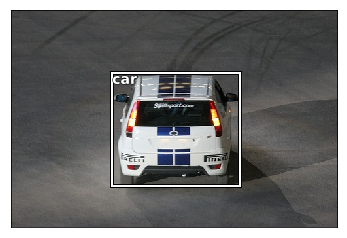

In [55]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]])

### Let's make a function to show multiple objects on a single image

In [57]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [58]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

(364, 480, 3)


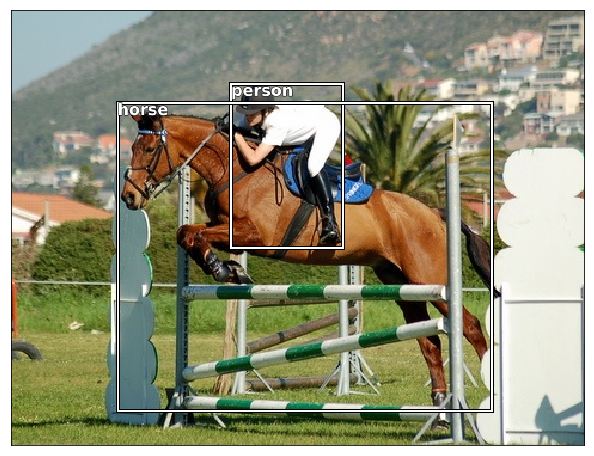

In [59]:
draw_idx(17)

# Next Complex step - Largest Item Classifier 
A *lambda function* is simply a way to define an anonymous function inline. Here we use it to describe how to sort the annotation for each image - by bounding box size (descending).

This snippet sorts the objets

    sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)

We subtract the upper left from the bottom right and multiply **(`np.product`)** the values to get an area.
    lambda x: np.product(x[0][-2:]-x[0][:2])

In [61]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

### dictionary comprehension - storing the biggest objects:

    {
        IMG_ID : largest bounding box,
        ...
    }

In [65]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

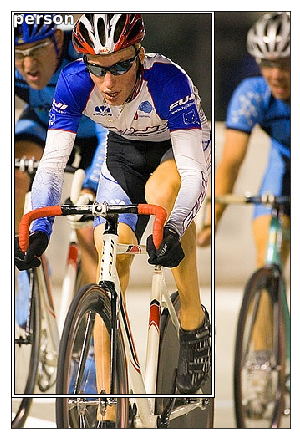

In [66]:
b,c = trn_lrg_anno[23]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[23]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)

### Let's store the largest object per file in a **`CSV`** file

In [67]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'

Often it's easiest to simply create a CSV of the data you want to model, rather than trying to create a custom dataset. Here we use Pandas to help us create a CSV of the image filename and class.

In [68]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
                   'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False)

### Make a Resnet model to learn 

#### Considerations

- The training images are different sized
- Since we are doing bounding boxes, many of the objects are near the edge, so we want to be careful not to cut the objects off the picture
- So we will put **`CropType.NO`** so we will "squish" instead

In [69]:
f_model = resnet34
sz=224
bs=64

From here it's just like Dogs vs Cats!

In [70]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms)

#### A note on Data Loaders

A data loader is an iterator that will provide a mini-batch of data ( subset). But first we need to ensure that we start at the beginning of the dataset. Pythons' **`iter()`** method will create an iterator object and start at the beginning of the dataset. And afterwards our iterator will have **`__next__`** that can be used to pull a mini-batch

In [74]:
md.trn_dl

#### Let's look at a single example

In [72]:
x,y=next(iter(md.val_dl))

#### Some observations

- not a numpy array
- not on the CPU
- `[torch.cuda.FloatTensor of size 2x3x224x224 (GPU 0)]` shape is wrong
- not numbers between 0 and 1

In [78]:
x[:2]


( 0 , 0 ,.,.) = 
  3.9125e-01  4.3014e-01  4.8172e-01  ...   1.7518e-01  3.2367e-01  4.0783e-01
  5.1636e-01  4.4973e-01  5.9202e-01  ...   1.7386e-01  2.3164e-01  3.6722e-01
  5.4416e-01  5.7267e-01  7.0099e-01  ...   5.7682e-02  2.2320e-01  3.5455e-01
                 ...                   ⋱                   ...                
  1.4604e+00  1.5029e+00  1.5195e+00  ...   7.8030e-01  5.6716e-01 -6.3922e-01
  9.3739e-01  1.0210e+00  1.1599e+00  ...   1.1281e+00  1.0895e+00  4.5857e-01
  5.8584e-01  4.5245e-01  2.9605e-01  ...   1.0003e+00  9.2495e-01  8.2729e-01

( 0 , 1 ,.,.) = 
  2.4041e-01  3.1444e-01  4.1422e-01  ...   3.3162e-01  4.7052e-01  5.4764e-01
  3.9737e-01  4.2156e-01  5.7304e-01  ...   3.3887e-01  3.8799e-01  5.2038e-01
  5.2462e-01  5.8245e-01  6.7485e-01  ...   2.5190e-01  4.0003e-01  5.1502e-01
                 ...                   ⋱                   ...                
  1.4721e+00  1.5019e+00  1.5077e+00  ...   6.0917e-01  4.4337e-01 -7.3978e-01
  8.4169e-01  9.

```python
imagenet_stats = A([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
inception_stats = A([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
inception_models = (inception_4, inceptionresnet_2)    

def tfms_from_stats(stats, sz, aug_tfms=None, max_zoom=None, pad=0, crop_type=CropType.RANDOM,
                    tfm_y=None, sz_y=None, pad_mode=cv2.BORDER_REFLECT):
    if aug_tfms is None: aug_tfms=[]
    ----------------------------------------------- NOTE THE MANIPULATION ----------------------------------
    tfm_norm = Normalize(*stats, tfm_y=tfm_y)
    tfm_denorm = Denormalize(*stats)
    ----------------------------------------------- NOTE THE MANIPULATION ----------------------------------
    val_crop = CropType.CENTER if crop_type==CropType.RANDOM else crop_type
    val_tfm = image_gen(tfm_norm, tfm_denorm, sz, pad=pad, crop_type=val_crop, tfm_y=tfm_y, sz_y=sz_y)
    trn_tfm=image_gen(tfm_norm, tfm_denorm, sz, tfms=aug_tfms, max_zoom=max_zoom,
                      pad=pad, crop_type=crop_type, tfm_y=tfm_y, sz_y=sz_y, pad_mode=pad_mode)
    return trn_tfm, val_tfm
```


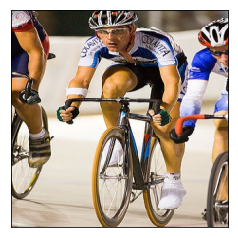

In [73]:
show_img(md.val_ds.denorm(to_np(x))[0]);

### Using Resnet 34

Get a pretrained learner

In [80]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

#### Find a learning rate

In [81]:
lrf=learn.lr_find(1e-5,100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████▊  | 25/32 [00:08<00:02,  2.84it/s, loss=14.9]


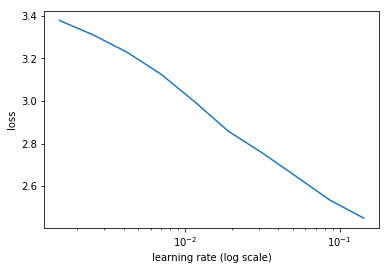

In [82]:
learn.sched.plot()

#### to change the truncation of the plot use the command below

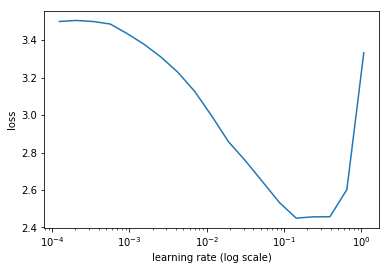

In [83]:
learn.sched.plot(n_skip=5, n_skip_end=1)

#### Set the learning rate

In [85]:
lr = 2e-2

In [86]:
learn.fit(lr, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.280753   0.604127   0.806941  



[0.60412693, 0.8069411069154739]

In [87]:
lrs = np.array([lr/1000,lr/100,lr])

### We freeze all layers except the last two layers, find new learning rate and retrain

In [88]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 27/32 [00:08<00:01,  3.26it/s, loss=3.45] 


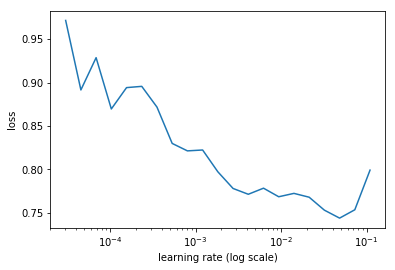

In [89]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [90]:
learn.fit(lrs/5, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.777971   0.556964   0.832782  



[0.5569643, 0.8327824547886848]

#### Accuracy is still at 83%

In [91]:
learn.unfreeze()

Accuracy isn't improving much - since many images have multiple different objects, it's going to be impossible to be that accurate.

In [93]:
learn.fit(lrs/5, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.676254   0.546998   0.834285  
    1      0.460609   0.533741   0.833233                  



[0.53374064, 0.8332331702113152]

In [94]:
learn.save('clas_one')

In [95]:
learn.load('clas_one')

In [97]:
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x,preds = to_np(x),to_np(probs)
preds = np.argmax(preds, -1)

### Let's look at the 20 classes 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


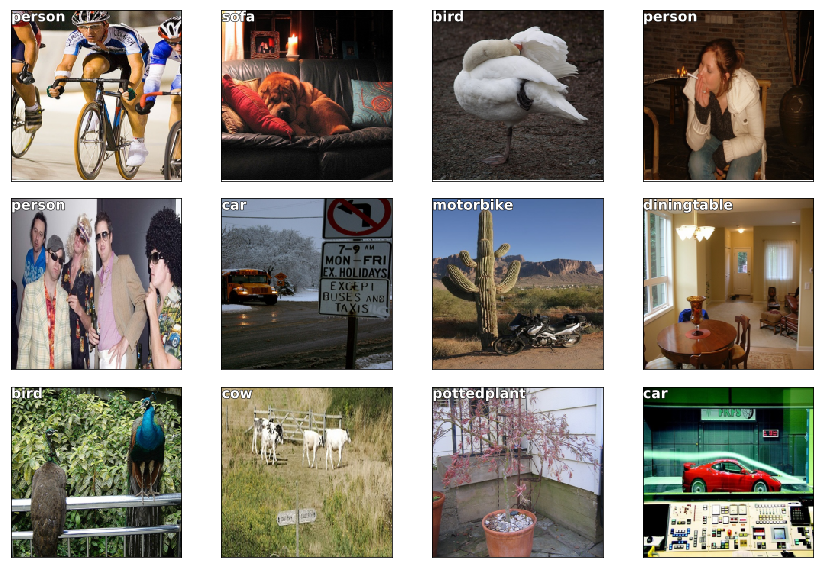

In [98]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

### Note on debuggers

You can use the python debugger `pdb` to step through code.

- `pdb.set_trace()` to set a breakpoint
- `%debug` magic to trace an error

Commands you need to know:

- s / n / c
- u / d
- p
- l

```
> <ipython-input-99-6d7dd6a3d3cc>(4)<module>()
-> ima=md.val_ds.denorm(x)[i]
(Pdb) h

Documented commands (type help <topic>):
========================================
EOF    c          d        h         list      q        rv       undisplay
a      cl         debug    help      ll        quit     s        unt      
alias  clear      disable  ignore    longlist  r        source   until    
args   commands   display  interact  n         restart  step     up       
b      condition  down     j         next      return   tbreak   w        
break  cont       enable   jump      p         retval   u        whatis   
bt     continue   exit     l         pp        run      unalias  where    

Miscellaneous help topics:
==========================
exec  pdb
```

Can view variables throughout the debugging process
```
(Pdb) n # will go to next step

(Pdb) l # will show the currentlocation
  1  	fig, axes = plt.subplots(3, 4, figsize=(12, 8))
  2  	for i,ax in enumerate(axes.flat):
  3  	    pdb.set_trace()
  4  ->	    ima=md.val_ds.denorm(x)[i]
  5  	    b = md.classes[preds[i]]
  6  	    ax = show_img(ima, ax=ax)
  7  	    draw_text(ax, (0,0), b)
  8  	plt.tight_layout()
[EOF]

(Pdb) s # will go into a function

(Pdb) c # continue to next break point
```

# Next Stage : Create a bounding box around an object

We know we can make a regression nn instead of a classification. This is accomplished by changing the last layer of the NN. Instead of Softmax, and use MSE, it is now a regression problem. We can have multiple outputs.

So what we will do is a multiple regression to predict the following values:
- top left x
- top left y
- lower right x
- lower right y

#### But what about the loss function?


In [100]:
BB_CSV = PATH/'tmp/bb.csv'

#### Transform the bounding box data

In [101]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False)

In [102]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '000012.jpg,96 155 269 350\n',
 '000017.jpg,77 89 335 402\n',
 '000023.jpg,1 2 461 242\n',
 '000026.jpg,124 89 211 336\n']

### Set our model and parameters

In [103]:
f_model=resnet34
sz=224
bs=64

### Tell `fast.ai` to make a continous network model

Set `continuous=True` to tell fastai this is a regression problem, which means it won't one-hot encode the labels, and will use MSE as the default crit.

Note that we have to tell the transforms constructor that our labels are coordinates, so that it can handle the transforms correctly.

Also, we use CropType.NO because we want to 'squish' the rectangular images into squares, rather than center cropping, so that we don't accidentally crop out some of the objects. (This is less of an issue in something like imagenet, where there is a single object to classify, and it's generally large and centrally located).

In [104]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True)

In [105]:
x,y=next(iter(md.val_dl))

In [106]:
ima=md.val_ds.denorm(to_np(x))[0]
b = bb_hw(to_np(y[0])); b

array([ 49.,   0., 131., 205.], dtype=float32)

#### Let's look at an example image with box

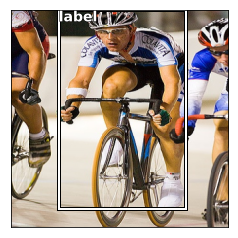

In [107]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], 'label')

### How add additional layers on the end of the Resnet (`custom head`)

fastai let's you use a `custom_head` to add your own module on top of a convnet, instead of the adaptive pooling and fully connected net which is added by default. In this case, we don't want to do any pooling, since we need to know the activations of each grid cell.

The final layer has 4 activations, one per bounding box coordinate. Our target is continuous, not categorical, so the MSE loss function used does not do any sigmoid or softmax to the module outputs.

In [108]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

#### Check the Model to see that the additional layer has been addedm

In [110]:
# learn.summary()

```
OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
              ....
              ....
             ('ReLU-121',
              OrderedDict([('input_shape', [-1, 512, 7, 7]),
                           ('output_shape', [-1, 512, 7, 7]),
                           ('nb_params', 0)])),
             ('BasicBlock-122',
              OrderedDict([('input_shape', [-1, 512, 7, 7]),
                           ('output_shape', [-1, 512, 7, 7]),
                           ('nb_params', 0)])),
             ('Flatten-123',
              OrderedDict([('input_shape', [-1, 512, 7, 7]),
                           ('output_shape', [-1, 25088]),
                           ('nb_params', 0)])),
                           
             ------------------- New layer ------------------------
             ('Linear-124',
              OrderedDict([('input_shape', [-1, 25088]),
                           ('output_shape', [-1, 4]),
                           ('trainable', True),
                           ('nb_params', 100356)]))])
             ------------------- New layer ------------------------                           
```

### Try and fit the model

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████▊  | 25/32 [00:04<00:01,  5.36it/s, loss=475] 


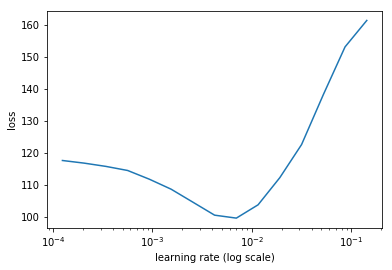

In [111]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

#### Set the learning rate

In [112]:
lr = 2e-3

#### Train

In [113]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      50.135777  34.477402 
    1      37.689602  29.124092                           
    2      31.387475  27.658106                           



[27.658106]

In [114]:
lrs = np.array([lr/100,lr/10,lr])

In [115]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      80.37384   175370041032704.0



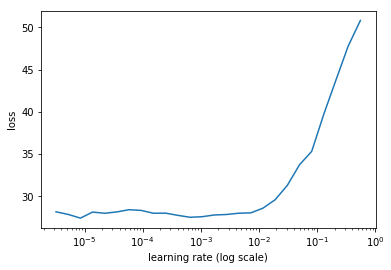

In [116]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [117]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      25.814654  23.127014 
    1      21.655237  21.125538                           
    2      17.600573  20.209145                           



[20.209145]

In [118]:
learn.freeze_to(-3)

In [119]:
learn.fit(lrs, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      16.644847  21.78323  
    1      14.667386  20.380457                           



[20.380457]

#### Save our Model

In [120]:
learn.save('reg4')

In [121]:
learn.load('reg4')

## Let's see how our model did!

Anytime there's a single subject, our model does decent. When there's multiple objects our model doesn't perform as well. Next week we will improve our model 

In [122]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


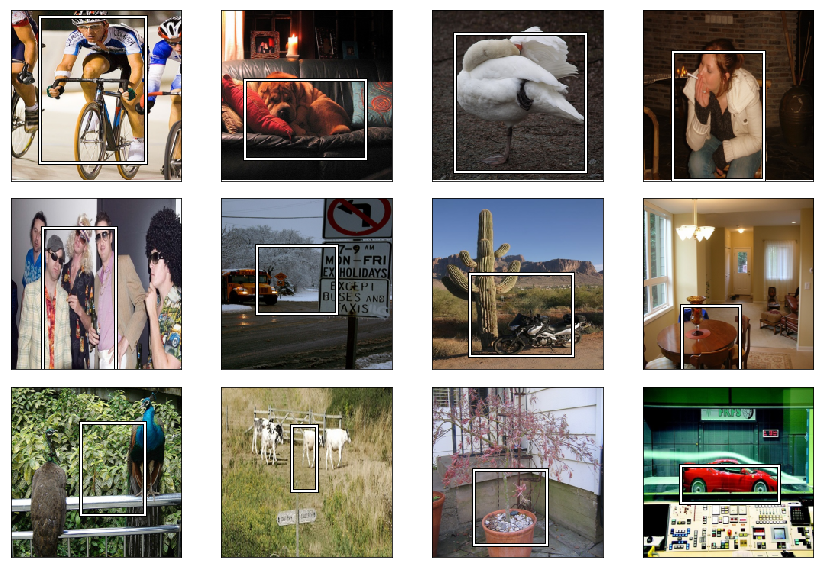

In [123]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()